# Toffoli-SWAP fidelity check

2020/1/6

origined by rum

---
In this code, two types of R-Toffoli gate are checked fidelity on real device

In [1]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

## import datetime
from datetime import datetime

## Import qiskit tools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

## import qiskit backend monitor
from  qiskit.tools.monitor import backend_monitor

## import qiskit readout error mitigation tools
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

---
# 1. Get device

In [2]:
IBMQ.load_account()

/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Here to choose provider

In [3]:
## keio-internal device
# provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='keio-students')

## reservations
provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='reservations')

## open device
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

### Define the backend device

In [4]:
device = provider.get_backend("ibmq_valencia")

---
# 2. Define circuit

### 2-2. Compose circuit

In [5]:
## define qubit label as num_qubits
num_qubits = len(device.configuration().gates[0].coupling_map)


## Define the list to store the circuit lists of each qubits of the processor
RTof_qc = []

## define init_list
init_list = [format(j, '02b') for j in range(4)]

## define qubit
control, target = [0, 1]

In [6]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(2, "q")
    cr = ClassicalRegister(2, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[control])
    if(init[1] == '1'):
        circuit.x(qr[target])

    ## R-Tof_m
    circuit.cx(qr[control], qr[target])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[control], cr[1])
    circuit.measure(qr[target], cr[0])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [7]:
RTof_qc[1].draw()

---
# 3. Run on QASM simulator

### 3-1. Execution

In [10]:
## define simulator
simulator = Aer.get_backend("qasm_simulator")

## define shots
shots = 8192

## define repeat length
in_len = len(init_list)

## define job
job_sim = execute(RTof_qc, backend = simulator, shots = shots)
result_sim = job_sim.result()

## define the list to imidiately store the counts of the each circuit
counts_sim = [result_sim.get_counts(init) for init in range(in_len)]

In [11]:
print('counts_sim = ', counts_sim)

counts_sim =  [{'00': 8192}, {'01': 8192}, {'11': 8192}, {'10': 8192}]


### 3-2. Plot the result

In [12]:
## define length of repeat
input_len = len(counts_sim)
output_bin = [format(num, '02b') for num in range(4)]

sim_data = [[(counts_sim[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]

In [13]:
print(sim_data)

[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0]]


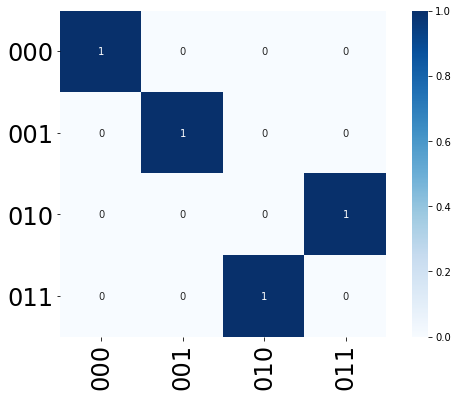

In [14]:
## axix range and data labels
### axix range
length=[num+0.5 for num in range(4)]
### labels 
X = [format(num, "03b") for num in range(4)]
Y = X

for sim_data in [sim_data]:
    ## set size
    fig,ax = plt.subplots(figsize=(9, 6))

    ## plot data
    sns.heatmap(sim_data, 
                vmin = 0.0,  ## define maximum value
                vmax=1.0,   ## defnie minimum value
                annot=True, ## show the numerical data
                square=True,  ## set heatmap to square shape
                cmap=plt.get_cmap('Blues') ## define the color
               )

    ## axis
    plt.xticks(length, 
               X, 
               rotation=90, 
               fontsize=24
              )
    plt.yticks(length, 
               Y, 
               rotation=0, 
               fontsize=24)
    
    plt.show()

---
# 4. Run on Realdevice

In [15]:
backend_monitor(device)

ibmq_valencia
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 33
    backend_version: 1.0.3
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    backend_name: ibmq_valencia
    n_uchannels: 8
    qubit_lo_range: [[4.244482429929797, 5.244482429929797], [4.150722822226201, 5.150722822226201], [4.292314966244938, 5.292314966244938], [4.334117245195646, 5.334117245195646], [4.459346739193721, 5.459346739193721]]
    dt: 3.5555555555555554e-09
    hamiltonian: {'description': 'Qubits are modelled as a two level system. Qubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing du

### 4-1. finding the qubit mapping list

In [16]:
## Get qubit coupling map
conf = device.configuration()
coupling_map = conf.coupling_map
print(coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


In [17]:
qubit_mapping = coupling_map
print("qubit_mapping = ", qubit_mapping)

qubit_mapping =  [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


### 4-2. Define mitigation circuit

In [18]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [19]:
print(meas_calibs)
print(state_labels)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e35ec88>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e35ed30>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e35ee48>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e35ef98>]
['00', '01', '10', '11']


### 4-3. Execution

In [20]:
## define shots
shots = 8192

## define the lists to store job_id
job_id_list = []
cal_job_id_list = []

## repeat # of qubit_mapping times
for mapping in qubit_mapping:
    
    ## job for circuit execution
    job_exp = execute(RTof_qc,
                      backend = device, 
                      shots = shots,
                      initial_layout=mapping,
                      optimization_level = 0
                     )
    job_id_list.append(job_exp.job_id())
    print('sent the job', mapping)

    
    ## job for meas_cal
    cal_job = execute(meas_calibs, 
                    backend = device,
                    shots=shots,
                    initial_layout=mapping,
                    optimization_level=0
                    )
    cal_job_id_list.append(cal_job.job_id())
    print('sent the cal_job', mapping)
    
#     ## get results
#     result_exp = job_exp.result()
#     result_cal = cal_job.result()
    
#     result_exp_list.append(result_exp)
#     result_cal_exp_list.append(result_cal)

print('job_id_list = ', job_id_list)
print('cal_job_id_list = ', cal_job_id_list)

sent the job [0, 1]
sent the cal_job [0, 1]
sent the job [1, 0]
sent the cal_job [1, 0]
sent the job [1, 2]
sent the cal_job [1, 2]
sent the job [1, 3]
sent the cal_job [1, 3]
sent the job [2, 1]
sent the cal_job [2, 1]
sent the job [3, 1]
sent the cal_job [3, 1]
sent the job [3, 4]
sent the cal_job [3, 4]
sent the job [4, 3]
sent the cal_job [4, 3]
job_id_list =  ['5e12f8abe7977f001127dcb5', '5e12f8b1ee2824001150d9e8', '5e12f8b839e9810012555ef7', '5e12f8bca36a940012148d04', '5e12f8c05879b80012ec8b7a', '5e12f8c506766d001137ca97', '5e12f8cab548320011261490', '5e12f8cea36a940012148d07']
cal_job_id_list =  ['5e12f8ae7272e100112de639', '5e12f8b5b54832001126148f', '5e12f8bbee2824001150d9e9', '5e12f8be39e9810012555ef8', '5e12f8c339e9810012555ef9', '5e12f8c8e7977f001127dcb6', '5e12f8cce7977f001127dcb8', '5e12f8d0efb76e0011439071']


In [19]:
job_id_list =  ['5e12f8abe7977f001127dcb5', '5e12f8b1ee2824001150d9e8', '5e12f8b839e9810012555ef7', '5e12f8bca36a940012148d04', '5e12f8c05879b80012ec8b7a', '5e12f8c506766d001137ca97', '5e12f8cab548320011261490', '5e12f8cea36a940012148d07']
cal_job_id_list =  ['5e12f8ae7272e100112de639', '5e12f8b5b54832001126148f', '5e12f8bbee2824001150d9e9', '5e12f8be39e9810012555ef8', '5e12f8c339e9810012555ef9', '5e12f8c8e7977f001127dcb6', '5e12f8cce7977f001127dcb8', '5e12f8d0efb76e0011439071']

### 4-4. retrieve the job and get the result

In [20]:
        ## Define the list to store the result_exp for error mitigation
result_exp_list = []
result_cal_exp_list = []

for job_id, cal_job_id in zip(job_id_list, cal_job_id_list) :
    ## retrieve jobs
    retrieved_job = device.retrieve_job(job_id)
    retrieved_cal_job = device.retrieve_job(cal_job_id)
    print("jobs were retrieved")
    result_exp = retrieved_job.result()
    print("got exp result")
    result_cal_exp = retrieved_cal_job.result()
    print("got cal_exp result")
    ## Append results_exp to the result_exp_list for error mitigation operation
    result_exp_list.append(result_exp)
    result_cal_exp_list.append(result_cal_exp)

print(result_exp_list)
print(result_cal_exp_list)

jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
[Result(backend_name='ibmq_valencia', backend_version='1.0.3', date=datetime.datetime(2019, 12, 26, 1, 12, 34, tzinfo=datetime.timezone.utc), execution_id='b71717f8-277c-11ea-a09b-ac1f6b47c318', header=Obj(backend_name='ibmq_valencia', backend_version='1.0.3'), job_id='5e040657a4bcd300114db617', qobj_id='30d8ee0f-9964-402d-8ea1-e900842a4eff', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=7935, 0x1=101, 0x2=42, 0x3=114)), header=Obj(clbit_labels=[['c', 0], ['c', 1]], creg_sizes=[['c', 2]], memory_slots=2, n_qubits=5, name='circuit0', qreg_siz

# Readout Error mitigation

The calibration matrix 

[[9.76318359e-01 3.97949219e-02 5.09033203e-02 2.56347656e-03]
 [1.61132812e-02 9.53613281e-01 9.76562500e-04 4.87060547e-02]
 [7.08007812e-03 2.44140625e-04 9.31152344e-01 4.22363281e-02]
 [4.88281250e-04 6.34765625e-03 1.69677734e-02 9.06494141e-01]]
Plot the calibration matrix (2D color grid plot)



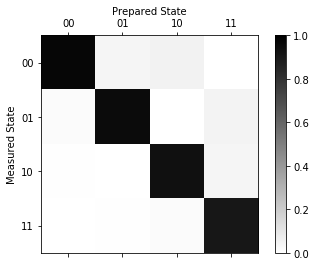

Average Measurement Fidelity: 0.941895 

The calibration matrix 

[[9.79614258e-01 5.33447266e-02 4.15039062e-02 2.31933594e-03]
 [6.22558594e-03 9.34204102e-01 0.00000000e+00 3.89404297e-02]
 [1.40380859e-02 9.76562500e-04 9.52148438e-01 5.12695312e-02]
 [1.22070312e-04 1.14746094e-02 6.34765625e-03 9.07470703e-01]]
Plot the calibration matrix (2D color grid plot)



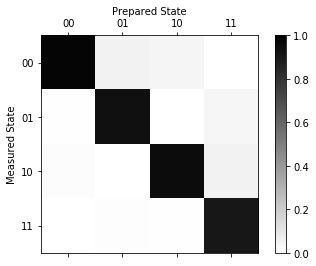

Average Measurement Fidelity: 0.943359 

The calibration matrix 

[[9.80590820e-01 5.16357422e-02 6.62841797e-02 3.17382812e-03]
 [5.00488281e-03 9.39453125e-01 7.32421875e-04 6.94580078e-02]
 [1.44042969e-02 7.32421875e-04 9.26269531e-01 4.76074219e-02]
 [0.00000000e+00 8.17871094e-03 6.71386719e-03 8.79760742e-01]]
Plot the calibration matrix (2D color grid plot)



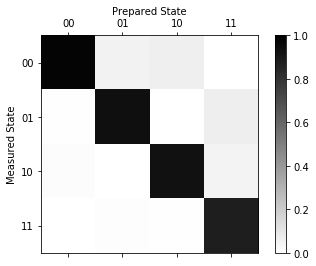

Average Measurement Fidelity: 0.931519 

The calibration matrix 

[[9.78149414e-01 5.16357422e-02 4.78515625e-02 2.56347656e-03]
 [8.05664062e-03 9.36035156e-01 3.66210938e-04 4.49218750e-02]
 [1.36718750e-02 6.10351562e-04 9.42382812e-01 5.02929688e-02]
 [1.22070312e-04 1.17187500e-02 9.39941406e-03 9.02221680e-01]]
Plot the calibration matrix (2D color grid plot)



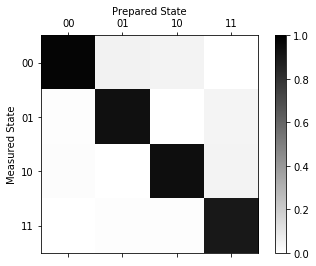

Average Measurement Fidelity: 0.939697 

The calibration matrix 

[[0.98352051 0.06420898 0.05004883 0.00231934]
 [0.01000977 0.92602539 0.0012207  0.04150391]
 [0.00646973 0.00183105 0.9375     0.06481934]
 [0.         0.00793457 0.01123047 0.89135742]]
Plot the calibration matrix (2D color grid plot)



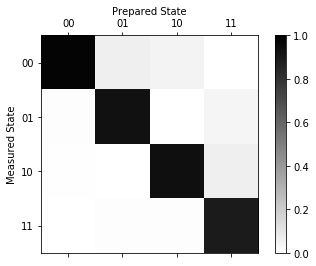

Average Measurement Fidelity: 0.934601 

The calibration matrix 

[[9.81567383e-01 4.23583984e-02 6.17675781e-02 2.44140625e-03]
 [1.22070312e-02 9.50439453e-01 9.76562500e-04 6.03027344e-02]
 [6.10351562e-03 2.44140625e-04 9.27734375e-01 4.01611328e-02]
 [1.22070312e-04 6.95800781e-03 9.52148438e-03 8.97094727e-01]]
Plot the calibration matrix (2D color grid plot)



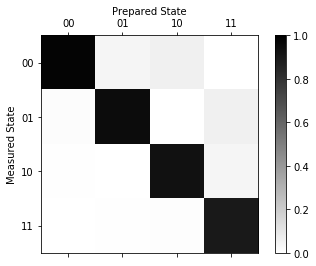

Average Measurement Fidelity: 0.939209 

The calibration matrix 

[[9.72534180e-01 4.67529297e-02 6.40869141e-02 4.51660156e-03]
 [1.08642578e-02 9.35913086e-01 7.32421875e-04 5.74951172e-02]
 [1.62353516e-02 1.09863281e-03 9.22363281e-01 4.21142578e-02]
 [3.66210938e-04 1.62353516e-02 1.28173828e-02 8.95874023e-01]]
Plot the calibration matrix (2D color grid plot)



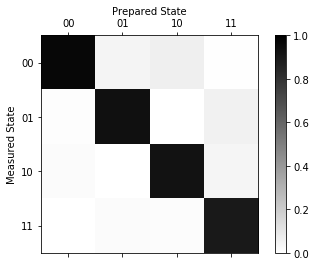

Average Measurement Fidelity: 0.931671 

The calibration matrix 

[[9.75219727e-01 6.31103516e-02 5.00488281e-02 3.66210938e-03]
 [1.55029297e-02 9.25659180e-01 8.54492188e-04 4.55322266e-02]
 [9.03320312e-03 7.32421875e-04 9.32250977e-01 5.73730469e-02]
 [2.44140625e-04 1.04980469e-02 1.68457031e-02 8.93432617e-01]]
Plot the calibration matrix (2D color grid plot)



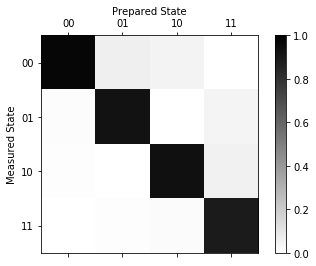

Average Measurement Fidelity: 0.931641 



In [21]:
meas_fitter_list = []

for result_cal_exp in result_cal_exp_list:
    
    ## define measurement fitter
    meas_fitter = CompleteMeasFitter(result_cal_exp, state_labels)
    meas_fitter_list.append(meas_fitter)
    
    print("The calibration matrix \n")
    print(meas_fitter.cal_matrix)

    ## Plot the calibration matrix
    print("Plot the calibration matrix (2D color grid plot)\n")
    meas_fitter.plot_calibration()

    ## The measurement fidelity
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(), "\n")

### Apply device calibration parameter to mitigate the result_exp

In [22]:
## define the list to store 
mitigated_list = []

## define repeat length
in_len = len(init_list)

## repeat (num_qubits) times
for result_exp, meas_fitter in zip(result_exp_list, meas_fitter_list):
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    
    ## get measurement error mitigated result
    mitigated_results = meas_filter.apply(result_exp)
    mitigated_counts = [mitigated_results.get_counts(init) for init in range(in_len)]

    ## Append mitigated_counts to mitigated_list
    mitigated_list.append(mitigated_counts)

### Show the mitigated counts

In [23]:
print("mitigated_list = ", mitigated_list, "\n")

mitigated_list =  [[{'11': 90.00757685882105, '01': 4.726102842411706e-11, '00': 8101.992423141109, '10': 2.303363055844443e-11}, {'11': 5.484827002300019e-14, '01': 7946.564941452917, '00': 133.48531958713662, '10': 111.94973895994652}, {'11': 8081.108917953453, '00': 80.56819221159901, '10': 30.3228898379139}, {'01': 37.771827974425314, '10': 8154.228172033071}], [{'11': 25.169682806158193, '01': 87.0047048949547, '00': 8079.825612296229, '10': 2.6571989016673653e-09}, {'01': 8192.0}, {'11': 8115.560903791224, '01': 54.5853921570706, '00': 21.853704051640925, '10': 6.46382464629283e-11}, {'11': 134.52575523097627, '01': 45.28490069476886, '00': 73.26990387041243, '10': 7938.919440203843}], [{'11': 20.366110578085486, '01': 92.11691443696652, '00': 8079.516974986761}, {'11': 2.5408860779285725e-11, '01': 7989.210887685069, '00': 162.63489756656162, '10': 40.15421474834448}, {'11': 8078.9494730327815, '00': 2.871832549544706e-09, '10': 113.05052697372177}, {'11': 87.37502658250236, '01

### post data processing

In [24]:
## define length of repeat
input_len = len(mitigated_list)
output_bin = [format(num, '02b') for num in range(4)]

mit_data = [[[(mitigated_list[mapping][inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(4)] for mapping in range(len(job_id_list))]

In [25]:
print("mit_data = ",mit_data, "\n")

mit_data =  [[[0.9890127469654674, 5.769168508803352e-15, 2.811722480278861e-15, 0.010987253034524054], [0.016294594676164138, 0.9700396657047018, 0.013665739619134096, 6.695345461792015e-18], [0.009834984400829958, 0.0, 0.003701524638417224, 0.9864634909611149], [0.0, 0.00461081884453434, 0.9953891811563808, 0.0]], [[0.9863068374385046, 0.0106206915154974, 3.2436510030119205e-13, 0.0030724710456736075], [0.0, 1.0, 0.0, 0.0], [0.002667688482866324, 0.006663255878548657, 7.890410945181677e-15, 0.9906690556385771], [0.008944080062306205, 0.005527941979341902, 0.9691063769780082, 0.016421600980343783]], [[0.9862691619856886, 0.011244740531856265, 0.0, 0.002486097482676451], [0.019852892769355666, 0.9752454696881188, 0.0049016375425225195, 3.101667575596402e-15], [3.50565496770594e-13, 0.0, 0.013800113155971896, 0.986199886844822], [0.0, 4.748834909671444e-13, 0.9893341032015176, 0.01066589679962187]], [[0.9829279738839029, 0.00722176395090772, 3.446872136892836e-14, 0.00985026216515482], 

In [26]:
def two_matrices_mean(matrix1, matrix2):
    mean = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(matrix1, matrix2)]
    return mean

def matrices_mean(array):
    mat = array[0]
    len_mat = len(array)
    for i in range(1, len_mat):
        res = two_matrices_mean(mat, array[i])
        mat = res
    return mat

In [27]:
mit_mean = matrices_mean(mit_data)

In [28]:
print("mit_mean = ", mit_mean)

mit_mean =  [[0.9880106297390071, 0.0015108327739870098, 9.14783505059057e-05, 0.010387059136510578], [0.008435057567186823, 0.9861498643942339, 0.005415078038526144, 5.394938782727013e-14], [0.012482421724893014, 0.004998777018630178, 0.006369494695375692, 0.9761493065612823], [0.006139250647963633, 0.013245765797075143, 0.9782387431407145, 0.002376240414704116]]


### Plot the output matrix

########################## Toffoli_SWAP ############################


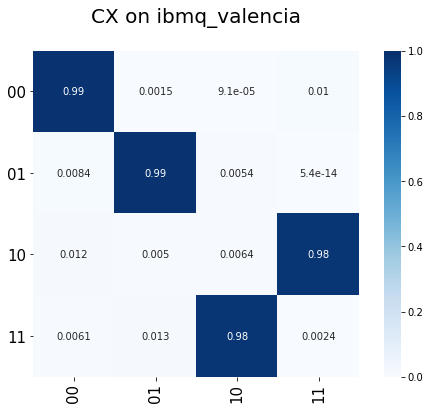

In [29]:
print("########################## Toffoli_SWAP ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(4)]
### labels 
X = [format(num, "02b") for num in range(4)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(9, 6))
## title
plt.title("CX on "+str(device)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(mit_mean, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues') ## define the color
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=15
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=15)

plt.show()

---
# Check Fidelity

In [30]:
dens_exp_cx = [[col/4 for col in row] for row in mit_mean]
dens_sim_cx = [[col/4 for col in row] for row in sim_data]

In [31]:
F_cx = np.trace(np.sqrt(np.dot(dens_exp_cx, dens_sim_cx)))
print("F_cx = ", F_cx, "\n")

F_cx =  0.9910250586754628 

